In [ ]:
# AWS IonQ Demo hosted by Harrisburg University

In [ ]:
# by Alex Khan 

In [1]:
# general imports
import numpy as np
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline
import string
import time

# AWS imports: Import Braket SDK modules
from braket.circuits import Circuit, Gate, Instruction, circuit, Observable
from braket.devices import LocalSimulator
from braket.aws import AwsDevice, AwsQuantumTask

In [2]:
# Please enter the S3 bucket you created during onboarding in the code below
my_bucket = f"amazon-braket-amazon-braket-hu-demo" # the name of the bucket
my_prefix = "results" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

In [3]:
# print all (the usual suspects) available gates currently available within SDK
gate_set = [attr for attr in dir(Gate) if attr[0] in string.ascii_uppercase]
print('Gate set supported by SDK:\n', gate_set)
print('\n') 

# the IonQ device
device = AwsDevice("arn:aws:braket:::device/qpu/ionq/ionQdevice")
supported_gates = device.properties.action['braket.ir.jaqcd.program'].supportedOperations
# print the supported gate set
print('Gate set supported by the IonQ device:\n', supported_gates)

Gate set supported by SDK:
 ['CCNot', 'CNot', 'CPhaseShift', 'CPhaseShift00', 'CPhaseShift01', 'CPhaseShift10', 'CSwap', 'CY', 'CZ', 'H', 'I', 'ISwap', 'PSwap', 'PhaseShift', 'Rx', 'Ry', 'Rz', 'S', 'Si', 'Swap', 'T', 'Ti', 'Unitary', 'V', 'Vi', 'X', 'XX', 'XY', 'Y', 'YY', 'Z', 'ZZ']


Gate set supported by the IonQ device:
 ['x', 'y', 'z', 'rx', 'ry', 'rz', 'h', 'cnot', 's', 'si', 't', 'ti', 'v', 'vi', 'xx', 'yy', 'zz', 'swap', 'i']


In [4]:
# Test using the local simulator
device = LocalSimulator()

In [ ]:
# Example 1 Bernstein Vazirani Algorithm

Creating the Bernstein Vazirani Algorithm
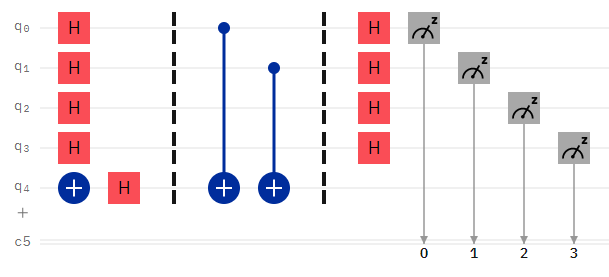

OPENQASM 2.0;
include "qelib1.inc";

qreg q[5];
creg c[5];

h q[0];
h q[1];
h q[2];
h q[3];
x q[4];
h q[4];

cx q[0],q[4];
cx q[1],q[4];

h q[0];
h q[1];
h q[2];
h q[3];
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[2] -> c[2];
measure q[3] -> c[3];

In [5]:
BV = Circuit().h(range(4)).x(4).h(4).cnot(0,4).cnot(1,4).h(range(4))
print(BV)

T  : |0|1|2|3|4|
                
q0 : -H---C-H---
          |     
q1 : -H---|-C-H-
          | |   
q2 : -H-H-|-|---
          | |   
q3 : -H-H-|-|---
          | |   
q4 : -X-H-X-X---

T  : |0|1|2|3|4|


In [7]:
# run circuit (execute single TASK)
device = LocalSimulator()
result = device.run(BV, shots=1000).result()
# get measurement shots
counts = result.measurement_counts
# print counts
print(counts)

Counter({'11001': 510, '11000': 490})


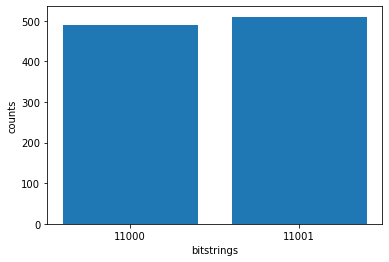

In [8]:
plt.bar(counts.keys(), counts.values());
plt.xlabel('bitstrings');
plt.ylabel('counts');

In [9]:
ionq = AwsDevice("arn:aws:braket:::device/qpu/ionq/ionQdevice")

In [10]:
# run circuit with a polling time of 5 days
ionq_task = ionq.run(BV, s3_folder, shots=10, poll_timeout_seconds=5*24*60*60)

# get id and status of submitted task
ionq_task_id = ionq_task.id
ionq_status = ionq_task.state()
# print('ID of task:', ionq_task_id)
print('Status of task:', ionq_status)

Status of task: CREATED


In [13]:
# print status
status = ionq_task.state()
print('Status of (reconstructed) task:', status)

Status of (reconstructed) task: QUEUED


In [55]:
# this is from AWS sample code. Credit goes to AWS

def recover_task(task_id):
    # recover task
    task_load = AwsQuantumTask(arn=task_id)

    # print status
    status = task_load.state()
    print('Status of (reconstructed) task:', status)

    # wait for job to complete
    # terminal_states = ['COMPLETED', 'FAILED', 'CANCELLED']
    if status == 'COMPLETED':
        # get results
        results = task_load.result()
        # print(rigetti_results)

        # get all metadata of submitted task
        metadata = task_load.metadata()
        # example for metadata
        shots = metadata['shots']
        machine = metadata['deviceArn']
        # print example metadata
        print("{} shots taken on machine {}.".format(shots, machine))

        # get measurement counts
        counts = results.measurement_counts
        print('Measurement counts:', counts)

        # plot results: see effects of noise
        plt.bar(counts.keys(), counts.values());
        plt.xlabel('bitstrings');
        plt.ylabel('counts');
        plt.tight_layout();
        plt.savefig('bell_ionq.png', dpi=700);

    elif status in ['FAILED', 'CANCELLED']:
        # print terminal message 
        print('Your task is in terminal status, but has not completed.')

    else:
        # print current status
        print('Sorry, your task is still being processed and has not been finalized yet.')

In [ ]:
# Example 2 Toffolio gate

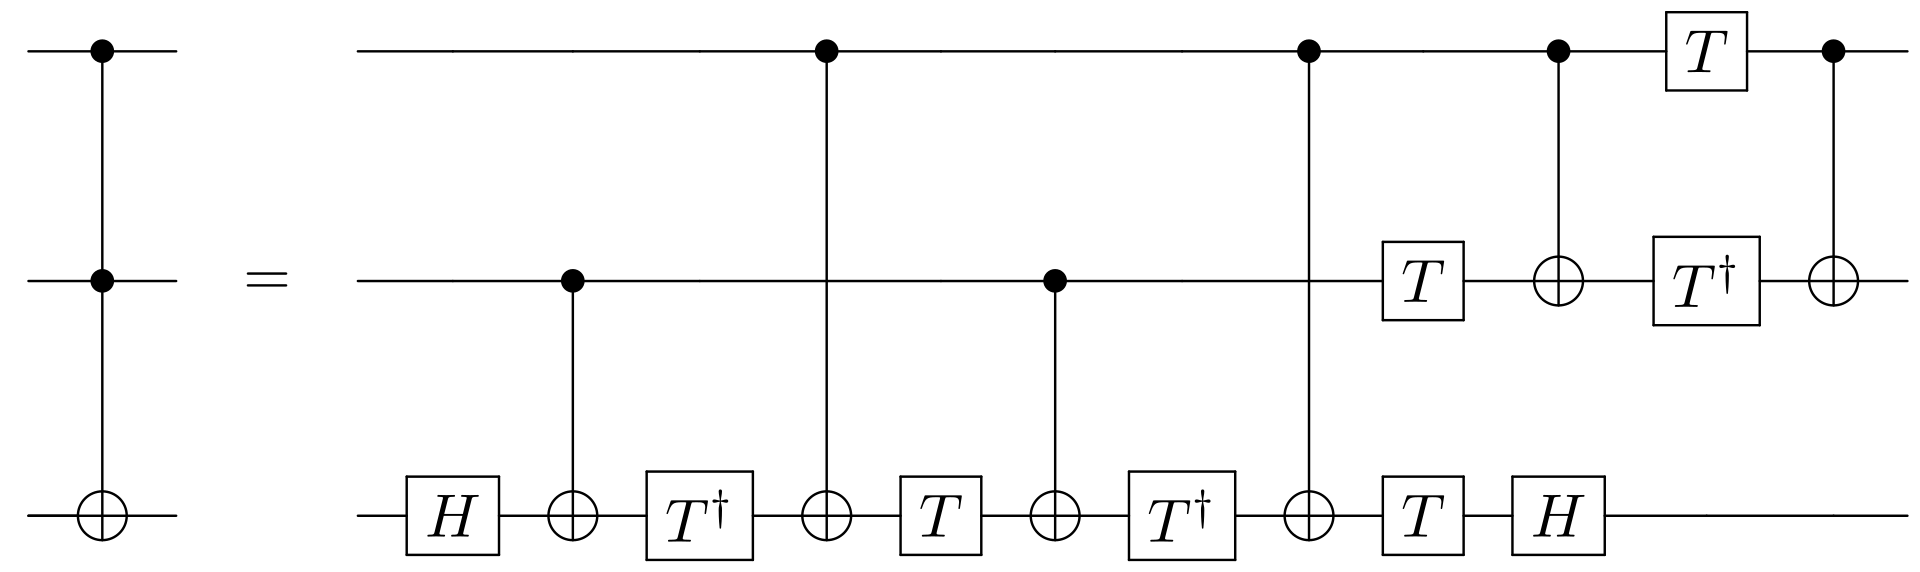

In [15]:
Toffoli = Circuit().h(2).cnot(1,2).ti(2).cnot(0,2).t(2).cnot(1,2).ti(2).cnot(0,2).t(1).t(2).cnot(0,1).h(2).t(0).ti(1).cnot(0,1)
print(Toffoli)

T  : |0|1|2 |3|4|5|6 |7|8|9 |10|
                                
q0 : --------C--------C-C-T--C--
             |        | |    |  
q1 : ---C----|---C-T--|-X-Ti-X--
        |    |   |    |         
q2 : -H-X-Ti-X-T-X-Ti-X-T-H-----

T  : |0|1|2 |3|4|5|6 |7|8|9 |10|


In [17]:
device = LocalSimulator()

In [22]:
T10=Circuit().x(0).h(2).cnot(1,2).ti(2).cnot(0,2).t(2).cnot(1,2).ti(2).cnot(0,2).t(1).t(2).cnot(0,1).h(2).t(0).ti(1).cnot(0,1)

In [29]:
# run circuit (execute single TASK)
device = LocalSimulator()
result = device.run(T10, shots=1000).result()
# get measurement shots
counts = result.measurement_counts
# print counts
print(counts)

Counter({'100': 1000})


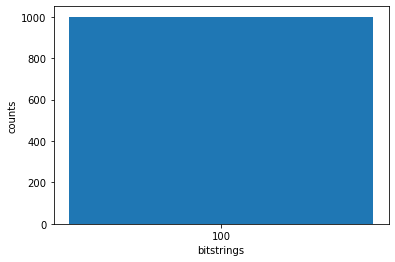

In [30]:
plt.bar(counts.keys(), counts.values());
plt.xlabel('bitstrings');
plt.ylabel('counts');

In [26]:
T01=Circuit().x(1).h(2).cnot(1,2).ti(2).cnot(0,2).t(2).cnot(1,2).ti(2).cnot(0,2).t(1).t(2).cnot(0,1).h(2).t(0).ti(1).cnot(0,1)

In [27]:
# run circuit (execute single TASK)
device = LocalSimulator()
result = device.run(T01, shots=1000).result()
# get measurement shots
counts = result.measurement_counts
# print counts
print(counts)

Counter({'010': 1000})


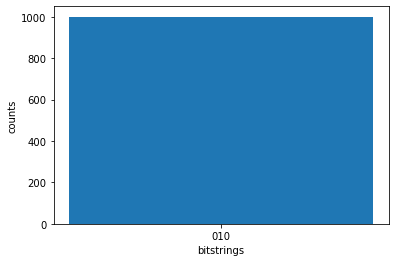

In [28]:
plt.bar(counts.keys(), counts.values());
plt.xlabel('bitstrings');
plt.ylabel('counts');

In [31]:
T11=Circuit().x(0).x(1).h(2).cnot(1,2).ti(2).cnot(0,2).t(2).cnot(1,2).ti(2).cnot(0,2).t(1).t(2).cnot(0,1).h(2).t(0).ti(1).cnot(0,1)

In [32]:
# run circuit (execute single TASK)
device = LocalSimulator()
result = device.run(T11, shots=1000).result()
# get measurement shots
counts = result.measurement_counts
# print counts
print(counts)

Counter({'111': 1000})


In [35]:
THH=Circuit().h(0).h(1).h(2).cnot(1,2).ti(2).cnot(0,2).t(2).cnot(1,2).ti(2).cnot(0,2).t(1).t(2).cnot(0,1).h(2).t(0).ti(1).cnot(0,1)

In [36]:
print(THH)

T  : |0|1|2 |3|4|5|6 |7|8|9 |10|
                                
q0 : -H------C--------C-C-T--C--
             |        | |    |  
q1 : -H-C----|---C-T--|-X-Ti-X--
        |    |   |    |         
q2 : -H-X-Ti-X-T-X-Ti-X-T-H-----

T  : |0|1|2 |3|4|5|6 |7|8|9 |10|


In [37]:
# run circuit (execute single TASK)
device = LocalSimulator()
result = device.run(THH, shots=1000).result()
# get measurement shots
counts = result.measurement_counts
# print counts
print(counts)

Counter({'000': 255, '010': 254, '100': 246, '111': 245})


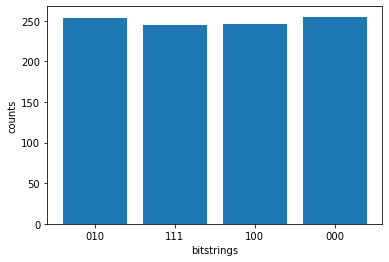

In [38]:
plt.bar(counts.keys(), counts.values());
plt.xlabel('bitstrings');
plt.ylabel('counts');

In [39]:
# run circuit with a polling time of 5 days
ionq_task = ionq.run(THH, s3_folder, shots=100, poll_timeout_seconds=5*24*60*60)

# get id and status of submitted task
ionq_task_id = ionq_task.id
ionq_status = ionq_task.state()
# print('ID of task:', ionq_task_id)
print('Status of task:', ionq_status)

Status of task: CREATED


In [1]:
print(ionq_task.id)

In [ ]:
#Results Comparison BV

Results from IBMQ BV results
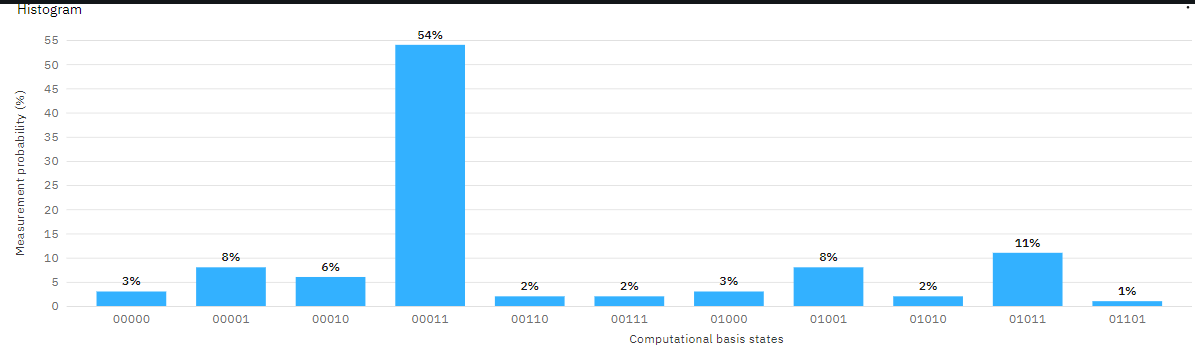

Status of (reconstructed) task: COMPLETED
10 shots taken on machine arn:aws:braket:::device/qpu/ionq/ionQdevice.
Measurement counts: Counter({'11000': 9, '11001': 1})


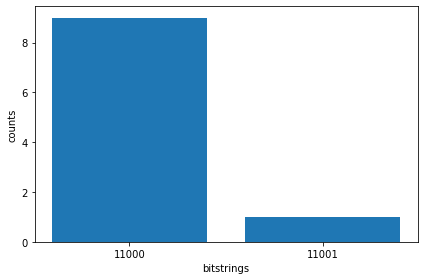

In [58]:
#BV example 10 shots cost $0.10
recover_task('task_id')

In [ ]:
Results from IBMQ Toffolio gate

IBM Athens QV32 results
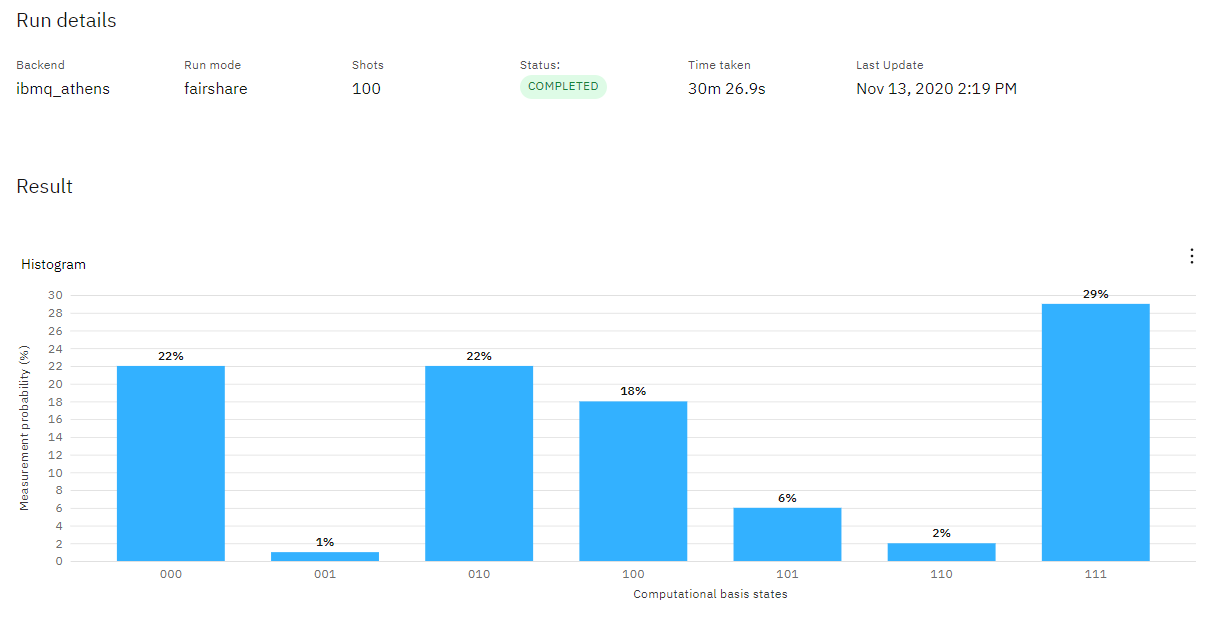


IBM Ourense QV16 results
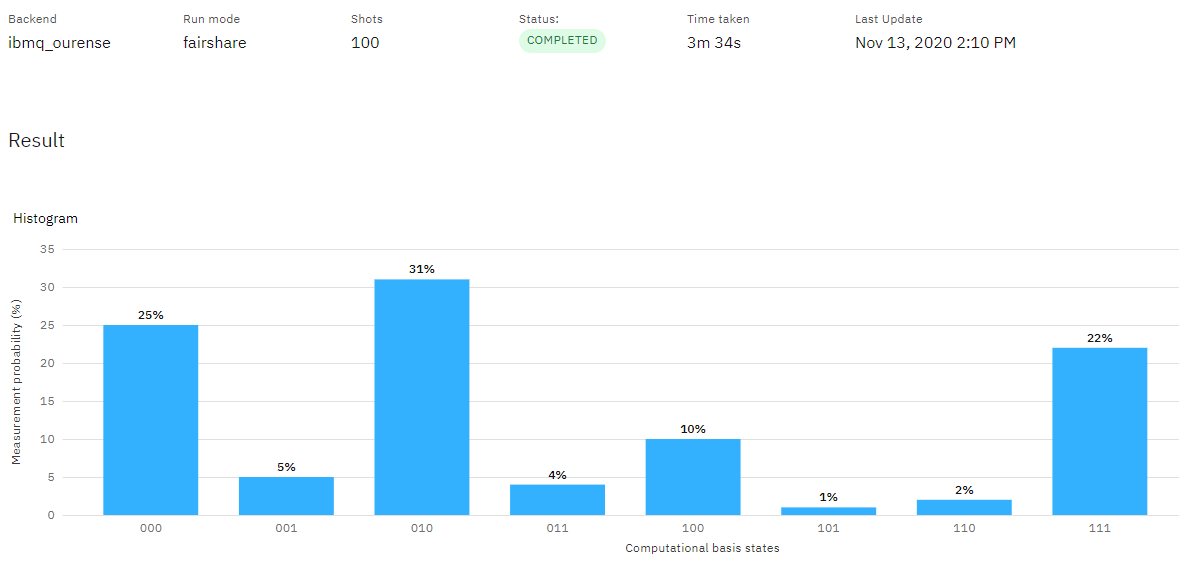

Status of (reconstructed) task: COMPLETED
100 shots taken on machine arn:aws:braket:::device/qpu/ionq/ionQdevice.
Measurement counts: Counter({'000': 32, '100': 24, '010': 22, '111': 19, '101': 2, '110': 1})


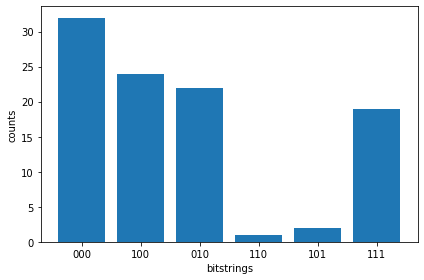

In [54]:
#Toffoli example 100shots cost $1.00  
recover_task('task_id')